# 03 - Model Training

**Purpose**: Train models, compare, save best one.

**Inputs**: `data/processed/features_v1_*.csv`

**Outputs**: `models/model_v1.joblib`

⚠️ **MEDICAL**: We prioritize RECALL - missing a recurrence is FATAL.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Sklearn - Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, cross_val_predict, StratifiedKFold

# Sklearn - Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Sklearn - Feature Selection
from sklearn.feature_selection import RFE, SelectFromModel

# Sklearn - Metrics
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    confusion_matrix, classification_report,
    fbeta_score, make_scorer, roc_auc_score
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Paths
DATA_PATH = Path('../data/processed/preprocessed_v1.csv')
MODELS_PATH = Path('../models')
MODELS_PATH.mkdir(exist_ok=True)

# Constants
TARGET_COLUMN = 'recidiva_exitus'
RANDOM_STATE = 42
MAX_FEATURES = 14

print("✅ Setup complet!")

✅ Setup complet!


In [2]:
# Carreguem el dataset preprocessat
df = pd.read_csv(DATA_PATH)

# Separem features (X) i target (y)
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

print(f"📊 Dataset shape: {df.shape}")
print(f"📊 Features: {X.shape[1]}")
print(f"\n🎯 Distribució del Target:")
print(y.value_counts())
print(f"\n📈 Percentatge de recidives: {y.mean()*100:.1f}%")
print(f"📉 Ratio desbalanceig: 1:{(1-y.mean())/y.mean():.1f}")

📊 Dataset shape: (154, 15)
📊 Features: 14

🎯 Distribució del Target:
recidiva_exitus
0    120
1     34
Name: count, dtype: int64

📈 Percentatge de recidives: 22.1%
📉 Ratio desbalanceig: 1:3.5


In [3]:
# Definim F2-score com a mètrica principal
def f2_score(y_true, y_pred):
    """F2-score: Dóna més pes al Recall (beta=2)"""
    return fbeta_score(y_true, y_pred, beta=2)

# Scorer per cross-validation
f2_scorer = make_scorer(fbeta_score, beta=2)

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Avalua un model amb múltiples mètriques"""
    metrics = {
        'Model': model_name,
        'F2-Score': fbeta_score(y_true, y_pred, beta=2),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred),
    }
    
    # AUC només si hi ha prediccions d'ambdues classes
    if len(np.unique(y_pred)) > 1:
        metrics['AUC'] = roc_auc_score(y_true, y_pred)
    else:
        metrics['AUC'] = np.nan
        
    return metrics

print("✅ Mètriques definides!")

✅ Mètriques definides!


In [4]:
# Pas 1: Entrenem un RF baseline per obtenir feature importances
print("🔄 Entrenant Random Forest baseline per feature selection...")

# Apliquem SMOTE abans del RF inicial
smote = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Entrenem RF amb totes les features
rf_baseline = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_baseline.fit(X_resampled, y_resampled)

# Obtenim importàncies
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 20 Features per Importància:")
print(feature_importance.head(20).to_string(index=False))

🔄 Entrenant Random Forest baseline per feature selection...

📊 Top 20 Features per Importància:
                       feature  importance
    grupo_de_riesgo_definitivo    0.163150
               afectacion_linf    0.118133
               estadiaje_pre_i    0.086917
Tratamiento_sistemico_realizad    0.083566
               grado_histologi    0.077987
               infiltracion_mi    0.072785
                           imc    0.072260
                      FIGO2023    0.067827
             recep_est_porcent    0.057078
                  rece_de_Ppor    0.055759
                          edad    0.048762
               tto_1_quirugico    0.042045
                   histo_defin    0.028483
                metasta_distan    0.025247


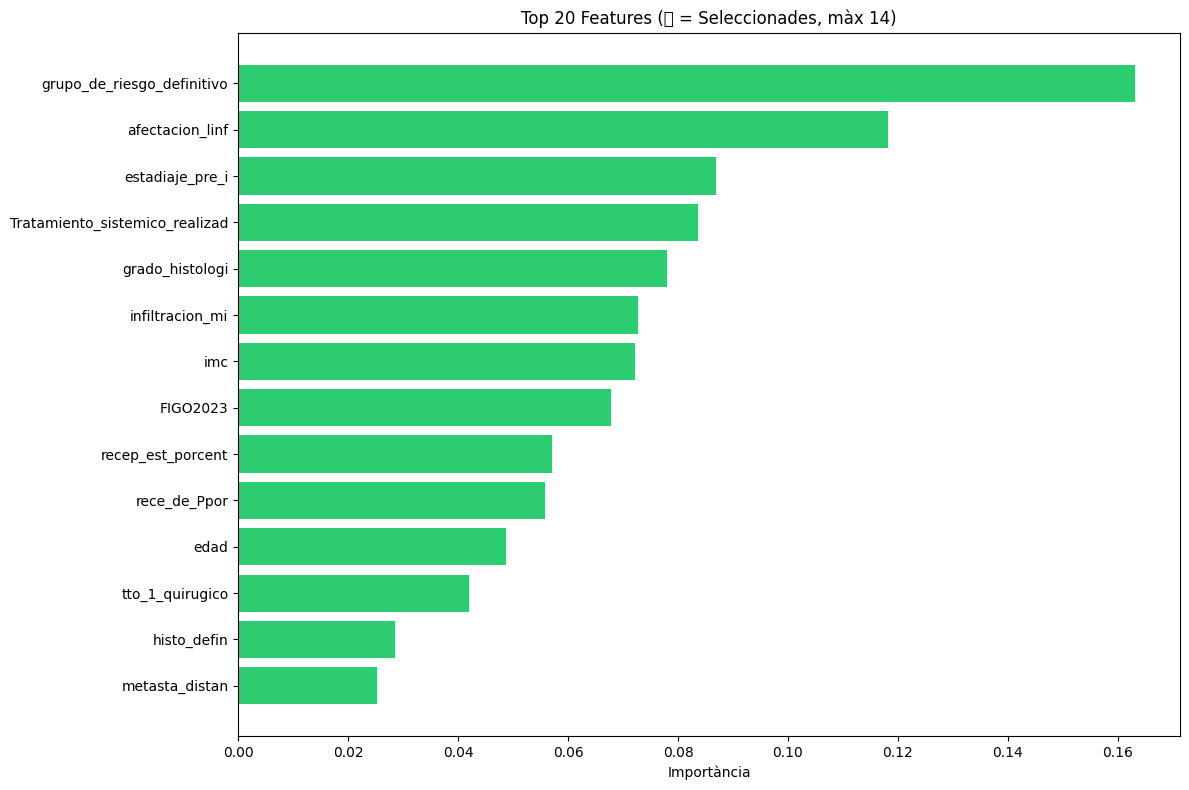


✅ 14 Features Seleccionades:
    1. grupo_de_riesgo_definitivo: 0.1632
    2. afectacion_linf: 0.1181
    3. estadiaje_pre_i: 0.0869
    4. Tratamiento_sistemico_realizad: 0.0836
    5. grado_histologi: 0.0780
    6. infiltracion_mi: 0.0728
    7. imc: 0.0723
    8. FIGO2023: 0.0678
    9. recep_est_porcent: 0.0571
   10. rece_de_Ppor: 0.0558
   11. edad: 0.0488
   12. tto_1_quirugico: 0.0420
   13. histo_defin: 0.0285
   14. metasta_distan: 0.0252


In [5]:
# Visualitzem les top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)

colors = ['#2ecc71' if i < MAX_FEATURES else '#95a5a6' for i in range(len(top_features))]

plt.barh(
    y=range(len(top_features)), 
    width=top_features['importance'].values,
    color=colors
)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importància')
plt.title(f'Top 20 Features (🟢 = Seleccionades, màx {MAX_FEATURES})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Guardem les top features
SELECTED_FEATURES = feature_importance.head(MAX_FEATURES)['feature'].tolist()
print(f"\n✅ {len(SELECTED_FEATURES)} Features Seleccionades:")
for i, feat in enumerate(SELECTED_FEATURES, 1):
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"   {i:2d}. {feat}: {imp:.4f}")

In [6]:
# Pas 2: Recursive Feature Elimination per refinar
print("🔄 Executant RFE per validar la selecció...")

# Usem les features pre-seleccionades
X_selected = X[SELECTED_FEATURES]
X_res_sel, y_res_sel = smote.fit_resample(X_selected, y)

# RFE amb RF
rf_rfe = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rfe = RFE(
    estimator=rf_rfe,
    n_features_to_select=MAX_FEATURES,
    step=1
)
rfe.fit(X_res_sel, y_res_sel)

# Features finals després de RFE
rfe_ranking = pd.DataFrame({
    'feature': SELECTED_FEATURES,
    'ranking': rfe.ranking_,
    'selected': rfe.support_
}).sort_values('ranking')

print("\n📊 Ranking RFE:")
print(rfe_ranking.to_string(index=False))

# Features finals
FINAL_FEATURES = rfe_ranking[rfe_ranking['selected']]['feature'].tolist()
print(f"\n✅ Features Finals: {len(FINAL_FEATURES)}")

🔄 Executant RFE per validar la selecció...

📊 Ranking RFE:
                       feature  ranking  selected
    grupo_de_riesgo_definitivo        1      True
               afectacion_linf        1      True
               estadiaje_pre_i        1      True
Tratamiento_sistemico_realizad        1      True
               grado_histologi        1      True
               infiltracion_mi        1      True
                           imc        1      True
                      FIGO2023        1      True
             recep_est_porcent        1      True
                  rece_de_Ppor        1      True
                          edad        1      True
               tto_1_quirugico        1      True
                   histo_defin        1      True
                metasta_distan        1      True

✅ Features Finals: 14


In [7]:
# Preparem les dades amb les features finals
X_final = X[FINAL_FEATURES]

# Escalar les dades
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)
X_scaled = pd.DataFrame(X_scaled, columns=FINAL_FEATURES)

print(f"📊 Dades finals: {X_scaled.shape}")
print(f"🎯 Target: {y.shape}")
print(f"\n📋 Features Finals:")
for i, f in enumerate(FINAL_FEATURES, 1):
    print(f"   {i}. {f}")

📊 Dades finals: (154, 14)
🎯 Target: (154,)

📋 Features Finals:
   1. grupo_de_riesgo_definitivo
   2. afectacion_linf
   3. estadiaje_pre_i
   4. Tratamiento_sistemico_realizad
   5. grado_histologi
   6. infiltracion_mi
   7. imc
   8. FIGO2023
   9. recep_est_porcent
   10. rece_de_Ppor
   11. edad
   12. tto_1_quirugico
   13. histo_defin
   14. metasta_distan


In [8]:
# Definim els models a comparar
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_STATE
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    'SVM': SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=RANDOM_STATE
    ),
    'Naive Bayes': GaussianNB()
}

print(f"🔄 Comparant {len(models)} models amb LOOCV + SMOTE...")
print("⏳ Això pot trigar uns minuts...\n")

🔄 Comparant 6 models amb LOOCV + SMOTE...
⏳ Això pot trigar uns minuts...



In [9]:
# LOOCV amb SMOTE integrat
loo = LeaveOneOut()
results = []

for name, model in models.items():
    print(f"📊 Avaluant {name}...")
    
    # Prediccions amb LOOCV
    y_pred_list = []
    y_true_list = []
    
    for train_idx, test_idx in loo.split(X_scaled):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Apliquem SMOTE només al train
        smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=min(5, (y_train == 1).sum() - 1))
        try:
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        except ValueError:
            # Si no hi ha prou samples, usem les dades originals
            X_train_res, y_train_res = X_train, y_train
        
        # Entrenem i prediem
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        
        y_pred_list.append(y_pred[0])
        y_true_list.append(y_test.values[0])
    
    # Convertim a arrays
    y_true_arr = np.array(y_true_list)
    y_pred_arr = np.array(y_pred_list)
    
    # Avaluem
    metrics = evaluate_model(y_true_arr, y_pred_arr, name)
    results.append(metrics)
    
    print(f"   ✅ F2-Score: {metrics['F2-Score']:.4f} | Recall: {metrics['Recall']:.4f}")

# Resultats en DataFrame
results_df = pd.DataFrame(results).sort_values('F2-Score', ascending=False)
print("\n" + "="*60)
print("📊 RESULTATS FINALS (ordenats per F2-Score)")
print("="*60)
print(results_df.to_string(index=False))

📊 Avaluant Random Forest...
   ✅ F2-Score: 0.7143 | Recall: 0.7353
📊 Avaluant XGBoost...
   ✅ F2-Score: 0.6609 | Recall: 0.6765
📊 Avaluant Gradient Boosting...
   ✅ F2-Score: 0.6897 | Recall: 0.7059
📊 Avaluant Logistic Regression...
   ✅ F2-Score: 0.7670 | Recall: 0.7941
📊 Avaluant SVM...
   ✅ F2-Score: 0.8101 | Recall: 0.8529
📊 Avaluant Naive Bayes...
   ✅ F2-Score: 0.7459 | Recall: 0.7941

📊 RESULTATS FINALS (ordenats per F2-Score)
              Model  F2-Score   Recall  Precision  F1-Score      AUC
                SVM  0.810056 0.852941   0.674419  0.753247 0.868137
Logistic Regression  0.767045 0.794118   0.675000  0.729730 0.842892
        Naive Bayes  0.745856 0.794118   0.600000  0.683544 0.822059
      Random Forest  0.714286 0.735294   0.641026  0.684932 0.809314
  Gradient Boosting  0.689655 0.705882   0.631579  0.666667 0.794608
            XGBoost  0.660920 0.676471   0.605263  0.638889 0.775735


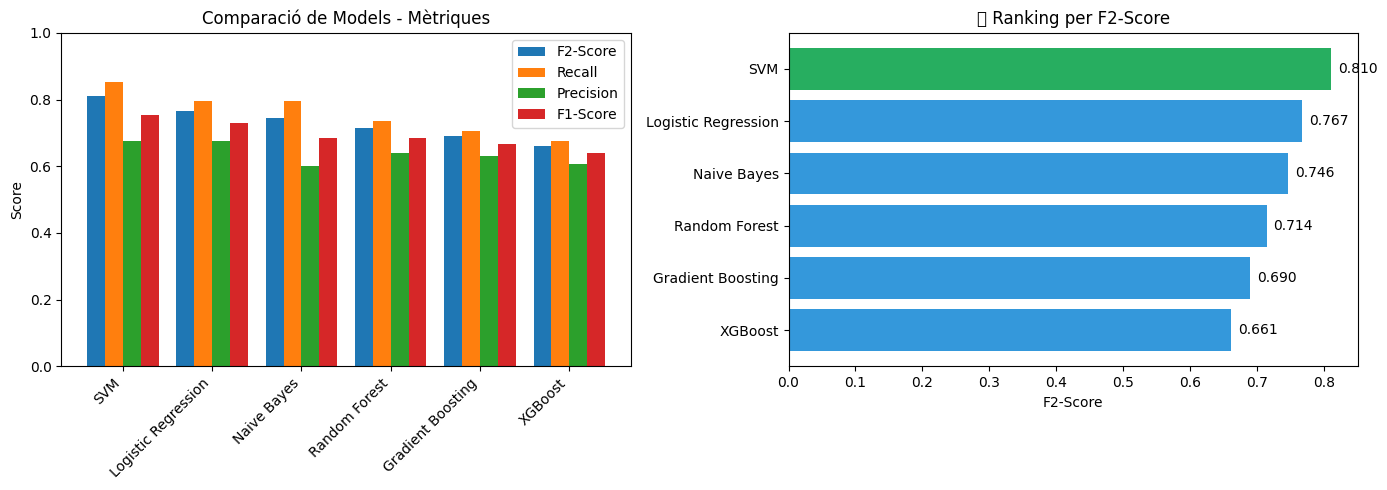


🏆 MILLOR MODEL: SVM (F2-Score: 0.8101)


In [10]:
# Visualització de resultats
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gràfic 1: Comparació de mètriques
metrics_to_plot = ['F2-Score', 'Recall', 'Precision', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric)

axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparació de Models - Mètriques')
axes[0].legend()
axes[0].set_ylim(0, 1)

# Gràfic 2: F2-Score ranking
colors = ['#27ae60' if i == 0 else '#3498db' for i in range(len(results_df))]
axes[1].barh(results_df['Model'], results_df['F2-Score'], color=colors)
axes[1].set_xlabel('F2-Score')
axes[1].set_title('🏆 Ranking per F2-Score')
axes[1].invert_yaxis()

for i, v in enumerate(results_df['F2-Score']):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Millor model
best_model_name = results_df.iloc[0]['Model']
best_f2 = results_df.iloc[0]['F2-Score']
print(f"\n🏆 MILLOR MODEL: {best_model_name} (F2-Score: {best_f2:.4f})")

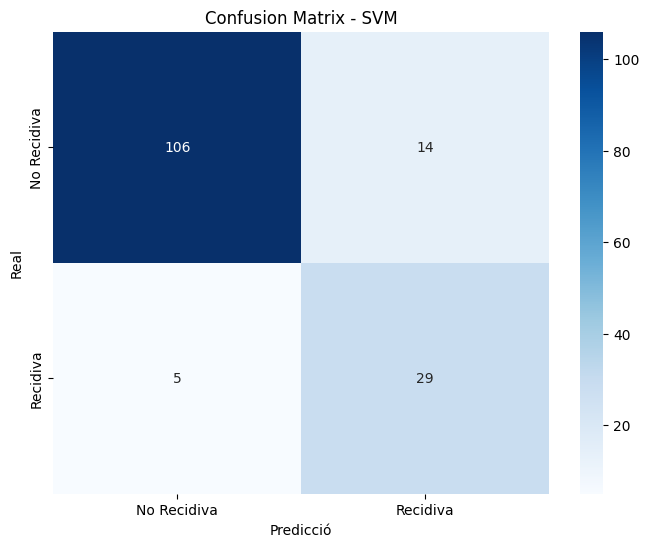


📋 Classification Report - SVM:
              precision    recall  f1-score   support

 No Recidiva       0.95      0.88      0.92       120
    Recidiva       0.67      0.85      0.75        34

    accuracy                           0.88       154
   macro avg       0.81      0.87      0.84       154
weighted avg       0.89      0.88      0.88       154



In [11]:
# Reentrenem el millor model per mostrar la CM
best_model = models[best_model_name]

# Prediccions finals amb LOOCV (ja calculades)
y_pred_best = []
for train_idx, test_idx in loo.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=min(5, (y_train == 1).sum() - 1))
    try:
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    except ValueError:
        X_train_res, y_train_res = X_train, y_train
    
    best_model.fit(X_train_res, y_train_res)
    y_pred_best.append(best_model.predict(X_test)[0])

y_pred_best = np.array(y_pred_best)

# Confusion Matrix
cm = confusion_matrix(y, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Recidiva', 'Recidiva'],
            yticklabels=['No Recidiva', 'Recidiva'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# Classification Report
print(f"\n📋 Classification Report - {best_model_name}:")
print(classification_report(y, y_pred_best, target_names=['No Recidiva', 'Recidiva']))

In [12]:
# Entrenem el model final amb TOTES les dades + SMOTE
print("🔄 Entrenant model final amb totes les dades...")

# SMOTE amb totes les dades
smote_final = SMOTE(random_state=RANDOM_STATE)
X_final_res, y_final_res = smote_final.fit_resample(X_scaled, y)

# Model final
final_model = models[best_model_name]
final_model.fit(X_final_res, y_final_res)

# Guardem el model
model_path = MODELS_PATH / 'model_v1.joblib'
joblib.dump(final_model, model_path)
print(f"✅ Model guardat: {model_path}")

# Guardem el scaler
scaler_path = MODELS_PATH / 'scaler_v1.joblib'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler guardat: {scaler_path}")

# Guardem la llista de features
features_path = MODELS_PATH / 'selected_features_v1.joblib'
joblib.dump(FINAL_FEATURES, features_path)
print(f"✅ Features guardades: {features_path}")

print(f"\n🎯 MODEL FINAL: {best_model_name}")
print(f"📊 Features utilitzades ({len(FINAL_FEATURES)}):")
for i, f in enumerate(FINAL_FEATURES, 1):
    print(f"   {i}. {f}")

🔄 Entrenant model final amb totes les dades...
✅ Model guardat: ..\models\model_v1.joblib
✅ Scaler guardat: ..\models\scaler_v1.joblib
✅ Features guardades: ..\models\selected_features_v1.joblib

🎯 MODEL FINAL: SVM
📊 Features utilitzades (14):
   1. grupo_de_riesgo_definitivo
   2. afectacion_linf
   3. estadiaje_pre_i
   4. Tratamiento_sistemico_realizad
   5. grado_histologi
   6. infiltracion_mi
   7. imc
   8. FIGO2023
   9. recep_est_porcent
   10. rece_de_Ppor
   11. edad
   12. tto_1_quirugico
   13. histo_defin
   14. metasta_distan


In [13]:
# Resum final
print("="*60)
print("📋 RESUM DEL TRAINING")
print("="*60)
print(f"""
🎯 Target: {TARGET_COLUMN}
📊 Samples totals: {len(y)}
📉 Casos positius (recidiva): {y.sum()} ({y.mean()*100:.1f}%)
📈 Casos negatius: {(1-y).sum()} ({(1-y.mean())*100:.1f}%)

🔧 METODOLOGIA:
   - Selecció de features: RF + RFE
   - Gestió desbalanceig: SMOTE + class_weight
   - Validació: Leave-One-Out CV (LOOCV)
   - Mètrica principal: F2-Score (prioritza Recall)

🏆 MILLOR MODEL: {best_model_name}
   - F2-Score: {results_df.iloc[0]['F2-Score']:.4f}
   - Recall: {results_df.iloc[0]['Recall']:.4f}
   - Precision: {results_df.iloc[0]['Precision']:.4f}
   - F1-Score: {results_df.iloc[0]['F1-Score']:.4f}

📁 ARXIUS GENERATS:
   - models/model_v1.joblib
   - models/scaler_v1.joblib
   - models/selected_features_v1.joblib

📋 FEATURES FINALS ({len(FINAL_FEATURES)}):
""")
for i, f in enumerate(FINAL_FEATURES, 1):
    print(f"   {i:2d}. {f}")
    
print("\n✅ Training completat! → Continua a 04_model_evaluation.ipynb")

📋 RESUM DEL TRAINING

🎯 Target: recidiva_exitus
📊 Samples totals: 154
📉 Casos positius (recidiva): 34 (22.1%)
📈 Casos negatius: 120 (77.9%)

🔧 METODOLOGIA:
   - Selecció de features: RF + RFE
   - Gestió desbalanceig: SMOTE + class_weight
   - Validació: Leave-One-Out CV (LOOCV)
   - Mètrica principal: F2-Score (prioritza Recall)

🏆 MILLOR MODEL: SVM
   - F2-Score: 0.8101
   - Recall: 0.8529
   - Precision: 0.6744
   - F1-Score: 0.7532

📁 ARXIUS GENERATS:
   - models/model_v1.joblib
   - models/scaler_v1.joblib
   - models/selected_features_v1.joblib

📋 FEATURES FINALS (14):

    1. grupo_de_riesgo_definitivo
    2. afectacion_linf
    3. estadiaje_pre_i
    4. Tratamiento_sistemico_realizad
    5. grado_histologi
    6. infiltracion_mi
    7. imc
    8. FIGO2023
    9. recep_est_porcent
   10. rece_de_Ppor
   11. edad
   12. tto_1_quirugico
   13. histo_defin
   14. metasta_distan

✅ Training completat! → Continua a 04_model_evaluation.ipynb


## Next Step
→ Go to `04_model_evaluation.ipynb`